In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2

In [2]:
def build_guassian_pyramid(image, num_octaves=4, num_scales=5, sigma=1.6):
  """
  Build a Gaussian Pyramid for the given image.

  Parameters:
  image          -Input grayscale image as a Numpy array.
  num_octaves    -Number of Octaves to generate.
  num_scales     -Number of Scale levels per octave.
  sigma          -Base Sigma value for Gaussian Blurring.

  Returns:
  Pyramid - A list of Octaves, each containing a List of blurred images.
  """
  pyramid = []
  # K determines the multiplicative factor between scales.
  k = 2**(1.0/(num_scales -3))
  current_image = image.copy()
  for octave in range(num_octaves):
    scales = []
    for s in range(num_scales):
      sigma_total = sigma * (k**s)
      blurred = gaussian_filter(current_image, sigma_total)
      scales.append(blurred)
    pyramid.append(scales)
    #Downsample the image by a factor of 2 for the next octave.
    current_image = current_image[::2, ::2]
  return pyramid




In [3]:
def compute_dog_pyramid(gaussian_pyramid):
  """
  Compute the Difference-of-Gaussian (DoG) pyramid.

  Parameters:
  Gaussian_pyramid - A gaussian pyramid as generated by build_gaussian_pyramid.

  Returns:
  dog_pyramid - A list of Octaves, each containing a the difference between consecutive scales.
  """
  dog_pyramid = []
  for scales in gaussian_pyramid:
    dog_scales = []
    for i in range(len(scales)):
      dog = scales[i] - scales[i - 1]
      dog_scales.append(dog)
    dog_pyramid.append(dog_scales)
  return dog_pyramid



In [4]:
def detect_keypoints(dog_pyramid, contrast_threshold=0.03):
  """
  Detect Keypoints by identifying local extrema in the Dog pyramid.

  Parameters:
  dog_pyramid - A list of Octaves, each containing a the difference between consecutive scales.
  contrast_threshold - Minimum absolute value to accept a candidate keypoint.

  Returns:
  keypoints - List of Detected keypoints as tuples(octave, scale_index, x,y value).
  """
  keypoints = []
  #Loop over each octave and scale(ignoring the first and last scale to allow neighborhood comparison).
  for octave_index, dog_scales in enumerate(dog_pyramid):
    #Iterate over scales, avoiding the first and  last of the octave.
    for s in range(1, len(dog_scales) - 1):
      current = dog_scales[s]
      prev = dog_scales[s - 1]
      nxt = dog_scales[s + 1]
      H, W = current.shape[:2]

     #Avoid border pixel
      for y in range(1, H - 1):
        for x in range(1, W - 1):
          value = current[y, x]
      if np.mean(abs(value)) < contrast_threshold:
          continue

          #Extract a 3x3 region from the current, previous, and next scales.
          patch_prev = prev[y - 1:y + 2, x - 1:x + 2]
          patch_curr = current[y - 1:y + 2, x - 1:x + 2]
          patch_next = nxt[y - 1:y + 2, x - 1:x + 2]
          patch = np.concatenate((patch_prev.flatten(),
                                  patch_curr.flatten(),
                                  patch_next.flatten()))
          #check if the center pixel is an extremum.
          if value ==np.max(patch) or value == np.min(patch):
            keypoint.append((octave_index, s, x, y, value))
    return keypoints

In [5]:
def manual_sift_detector(image, num_octaves=4, num_scales=5, sigma=1.6, contrast_threshold=0.03):
  """
  Apply a basic manual SIFT Detector to an image.

  Parameters:
  image             :Input grayscale image as a Numpy array.
  num_octaves       :Number of Octaves used in the pyramid.
  num_scales        :Number of scale levels per Octave.
  Sigma             :Initial sigma for Gaussian Blur.
  Contrast_threshold:Threshold to filter out low-contrast keypoints.

  Returns:
    Keypoints - List of keypoints Detected across octaves.
  """
  #Convert image to float32 to ensure precision in computations.
  img = image.astype(np.float32)
  #Build the Gaussian pyramid.
  gaussian_pyramid = build_guassian_pyramid(image, num_octaves, num_scales, sigma)
  # Compute the Difference-of-Gaussian pyramid.
  dog_pyramid = compute_dog_pyramid(gaussian_pyramid)
  #Detect keypoints in the DoG pyramid.
  keypoints = detect_keypoints(dog_pyramid, contrast_threshold)
  return keypoints

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_match_keypoints(image1_path, image2_path):
    """
    Detect and match keypoints between two images using OpenCV's SIFT and BFMatcher.

    Parameters:
        image1_path (str): Path to the first image.
        image2_path (str): Path to the second image.

    Returns:
        None: Displays the side-by-side visualization of matched keypoints.
    """
    # Load images in grayscale
    image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # Match descriptors using BFMatcher with L2 norm
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw matches on a combined image
    matched_image = cv2.drawMatches(
        image1, keypoints1,
        image2, keypoints2,
        matches[:50],  # Show top 50 matches
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Display the result using Matplotlib
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title("Matched Keypoints")
    plt.axis("off")
    plt.show()

    # Detect and match keypoints
    detect_and_match_keypoints(image1_path, image2_path)


Successfully downloaded box.png
Successfully downloaded box_in_scene.png

Using Image 1: box.png
Using Image 2: box_in_scene.png

Loaded Image 1: box.png (Shape: (223, 324))
Loaded Image 2: box_in_scene.png (Shape: (384, 512))
SIFT detector created successfully.
Detecting keypoints and computing descriptors...
Detected 604 keypoints in Image 1.
Detected 969 keypoints in Image 2.
Descriptors computed for Image 1. Shape: (604, 128)
Descriptors computed for Image 2. Shape: (969, 128)
Visualizing detected keypoints on individual images...


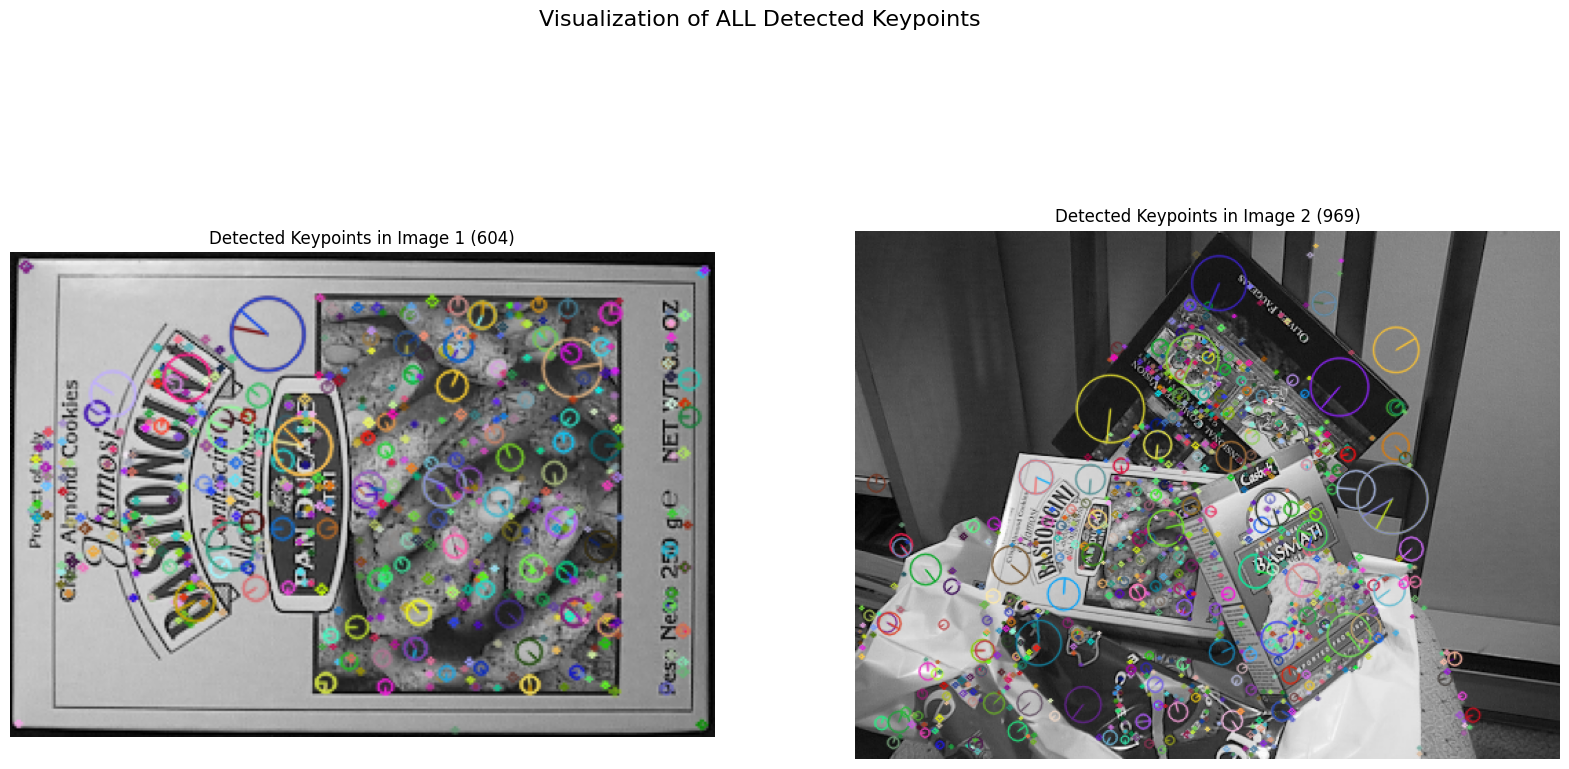


Matching descriptors using BFMatcher (Brute-Force)...
Found 260 matches.
Visualizing the top 100 matches...

Close the keypoint and matching visualization window(s) to exit.


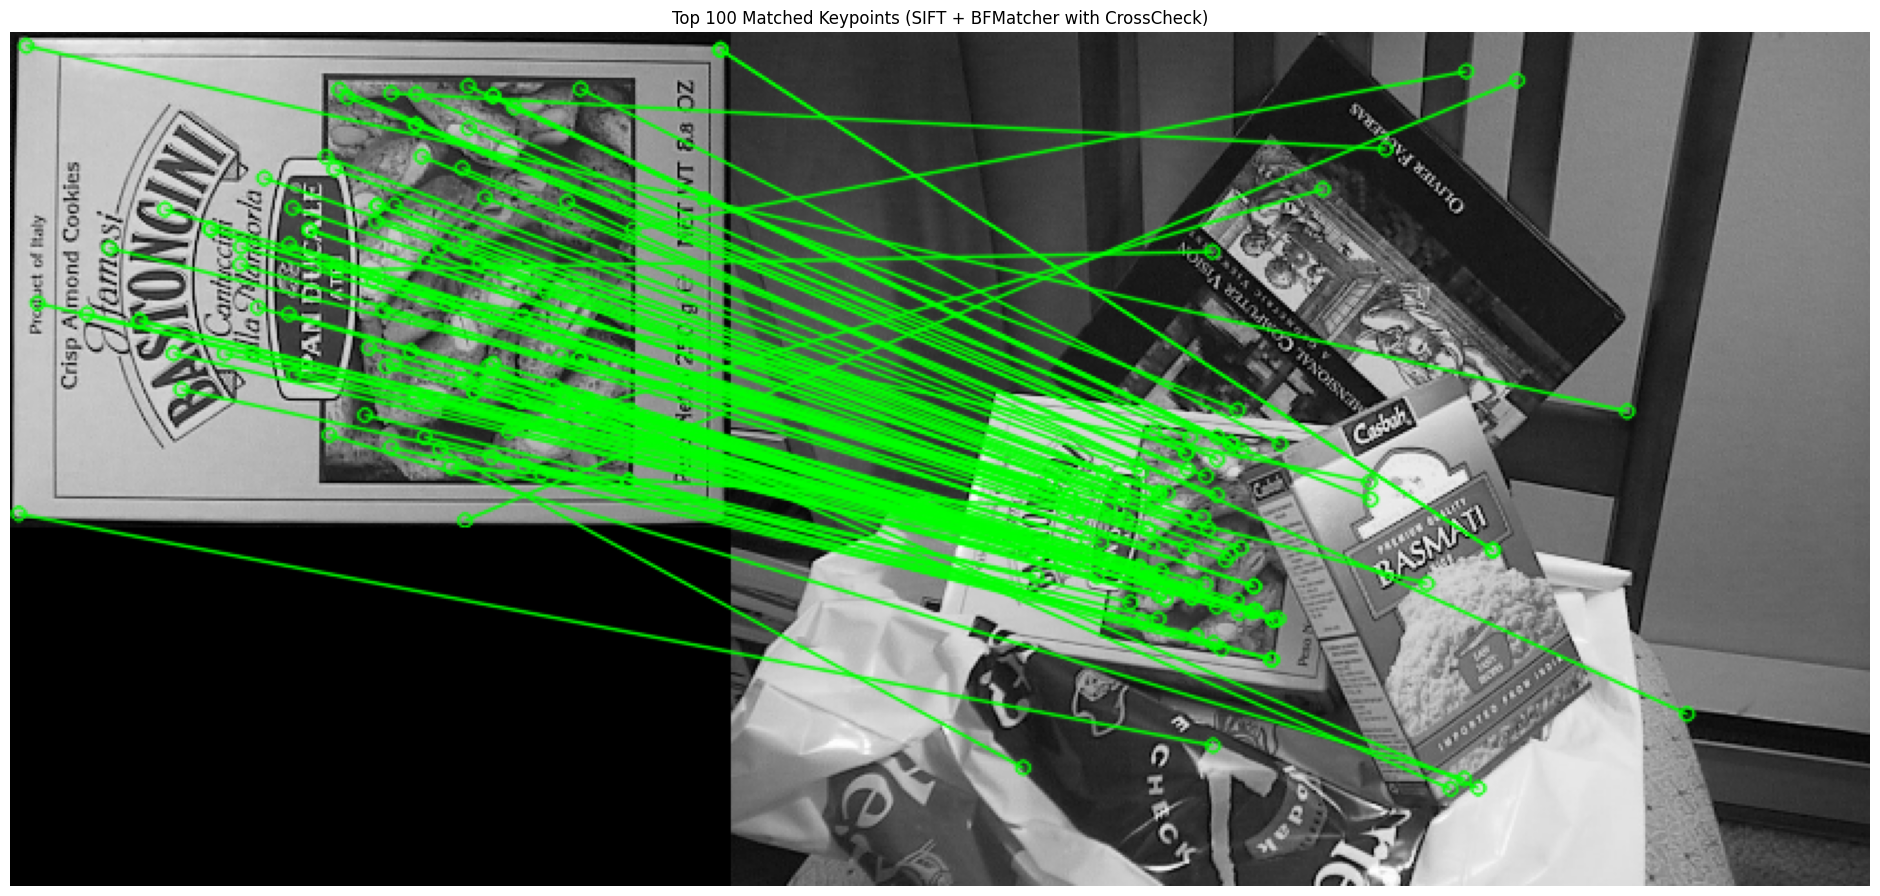

In [8]:
# 1. --- IMPORTS ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request

# 2. --- FEATURE DETECTION AND MATCHING FUNCTION ---
def detect_visualize_and_match(image1_path, image2_path, num_matches_to_show=100):
    """
    Detect keypoints, visualize them on individual images, print descriptor info,
    and match keypoints between two images using OpenCV's SIFT and BFMatcher.

    Parameters:
        image1_path (str): Path to the first image.
        image2_path (str): Path to the second image.
        num_matches_to_show (int): Number of best matches to visualize.

    Returns:
        None: Displays visualizations of detected keypoints and matched keypoints.
    """
    # --- 1. Load Images ---
    if not os.path.exists(image1_path):
        print(f"Error: Image file not found at {image1_path}")
        return
    if not os.path.exists(image2_path):
        print(f"Error: Image file not found at {image2_path}")
        return

    # Load images in grayscale
    image1_gray = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    image2_gray = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    # Load images in color for drawing keypoints later
    image1_color = cv2.imread(image1_path)
    image2_color = cv2.imread(image2_path)

    if image1_gray is None or image1_color is None:
        print(f"Error: Could not load image 1 from {image1_path}")
        return
    if image2_gray is None or image2_color is None:
        print(f"Error: Could not load image 2 from {image2_path}")
        return

    print(f"Loaded Image 1: {image1_path} (Shape: {image1_gray.shape})")
    print(f"Loaded Image 2: {image2_path} (Shape: {image2_gray.shape})")

    # --- 2. Initialize SIFT Detector ---
    try:
        sift = cv2.SIFT_create()
        print("SIFT detector created successfully.")
    except cv2.error as e:
         print("\n----------------------------------------------------------")
         print("ERROR creating SIFT detector.")
         print("You might need to install the contrib modules:")
         print("pip install opencv-python opencv-contrib-python")
         print("Note: SIFT is patented and might not be available in all OpenCV distributions.")
         print(f"Original error: {e}")
         print("----------------------------------------------------------\n")
         return # Exit if SIFT fails


    # --- 3. Detect Keypoints and Compute Descriptors ---
    print("Detecting keypoints and computing descriptors...")
    keypoints1, descriptors1 = sift.detectAndCompute(image1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2_gray, None)

    print(f"Detected {len(keypoints1)} keypoints in Image 1.")
    print(f"Detected {len(keypoints2)} keypoints in Image 2.")

    # --- 4. Descriptor Information ---
    if descriptors1 is not None:
        print(f"Descriptors computed for Image 1. Shape: {descriptors1.shape}")
    else:
        print("No descriptors computed for Image 1.")

    if descriptors2 is not None:
        print(f"Descriptors computed for Image 2. Shape: {descriptors2.shape}")
    else:
        print("No descriptors computed for Image 2.")

    # --- 5. Visualize Detected Keypoints on Individual Images ---
    print("Visualizing detected keypoints on individual images...")
    # Use DRAW_RICH_KEYPOINTS to show size and orientation
    img1_keypoints = cv2.drawKeypoints(image1_color.copy(), keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Use copy for safety
    img2_keypoints = cv2.drawKeypoints(image2_color.copy(), keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Use copy for safety

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Keypoints in Image 1 ({len(keypoints1)})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Keypoints in Image 2 ({len(keypoints2)})")
    plt.axis("off")
    plt.suptitle("Visualization of ALL Detected Keypoints", fontsize=16)
    plt.show(block=False) # Use block=False if you want the script to continue to matching immediately

    # --- 6. Match Descriptors ---
    if descriptors1 is None or descriptors2 is None or len(keypoints1) == 0 or len(keypoints2) == 0:
        print("\nCannot perform matching: Not enough keypoints or descriptors found.")
        # Keep matplotlib windows open until user closes them
        if plt.get_fignums(): # Check if any figures are open
             print("\nClose the keypoint visualization window(s) to exit.")
             plt.show() # This will now block until windows are closed
        return

    print("\nMatching descriptors using BFMatcher (Brute-Force)...")
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    print(f"Found {len(matches)} matches.")

    # --- 7. Visualize Matched Keypoints ---
    num_matches_to_show = min(num_matches_to_show, len(matches))
    print(f"Visualizing the top {num_matches_to_show} matches...")

    matched_image = cv2.drawMatches(
        image1_color, keypoints1,
        image2_color, keypoints2,
        matches[:num_matches_to_show],
        None,
        matchColor=(0, 255, 0),
        singlePointColor=(255, 0, 0),
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # --- 8. Display the Result ---
    plt.figure(figsize=(24, 12))
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Top {num_matches_to_show} Matched Keypoints (SIFT + BFMatcher with CrossCheck)")
    plt.axis("off")
    print("\nClose the keypoint and matching visualization window(s) to exit.")
    plt.show() # This will block until all plot windows are closed


# 3. --- IMAGE DOWNLOAD FUNCTION ---
def download_image(url, save_path):
    """Downloads an image from a URL if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)} from {url}...")
        try:
            urllib.request.urlretrieve(url, save_path)
            img = cv2.imread(save_path)
            if img is None:
                 print(f"Error: Failed to download or save image correctly from {url} to {save_path}. File might be corrupted or URL invalid.")
                 return False
            print(f"Successfully downloaded {os.path.basename(save_path)}")
            return True
        except Exception as e:
            print(f"Error downloading {url}: {e}")
            return False
    else:
        print(f"Image {os.path.basename(save_path)} already exists.")
        img = cv2.imread(save_path)
        if img is None:
             print(f"Error: Existing file {save_path} seems corrupted or is not a valid image. Trying to re-download...")
             try:
                 os.remove(save_path)
             except OSError as e:
                 print(f"Error removing corrupted file {save_path}: {e}")
                 return False
             return download_image(url, save_path)
        return True


# 4. --- MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    # Define URLs and local filenames
    url1 = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box.png"
    url2 = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box_in_scene.png"
    image1_filename = "box.png"
    image2_filename = "box_in_scene.png"

    # Attempt to download images
    download_ok1 = download_image(url1, image1_filename)
    download_ok2 = download_image(url2, image2_filename)

    # Fallback logic (optional, uses dummy images if download fails)
    if not download_ok1:
        print("Falling back to dummy image 1 because download failed.")
        image1_filename = "dummy_image1.png"
        if not os.path.exists(image1_filename):
             dummy_img = np.zeros((200, 300, 3), dtype=np.uint8)
             cv2.rectangle(dummy_img, (50, 50), (150, 150), (0, 255, 0), 5)
             cv2.putText(dummy_img, "Dummy1", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
             cv2.imwrite(image1_filename, dummy_img)

    if not download_ok2:
        print("Falling back to dummy image 2 because download failed.")
        image2_filename = "dummy_image2.png"
        if not os.path.exists(image2_filename):
             dummy_img = np.zeros((200, 300, 3), dtype=np.uint8)
             cv2.circle(dummy_img, (220, 100), 40, (0, 0, 255), -1)
             cv2.putText(dummy_img, "Dummy2", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
             cv2.imwrite(image2_filename, dummy_img)


    # --- RUN THE DETECTION AND MATCHING ---
    print(f"\nUsing Image 1: {image1_filename}")
    print(f"Using Image 2: {image2_filename}\n")

    # Ensure the images to be used actually exist before calling the function
    if os.path.exists(image1_filename) and os.path.exists(image2_filename):
        detect_visualize_and_match(image1_filename, image2_filename, num_matches_to_show=100)
    else:
        print("Error: One or both specified image files do not exist. Cannot proceed.")
        print(f"Checked path 1: {os.path.abspath(image1_filename)}")
        print(f"Checked path 2: {os.path.abspath(image2_filename)}")